In [1]:
import numpy as np, torch, matplotlib.pyplot as plt, pytorch_lightning
from tqdm.auto import tqdm

from os.path import join, basename, dirname, expanduser
import sys
sys.path.append('../src')
import gta.recording_videos

/home/tsbertalan/.virtualenvs/GTARacer/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  """Entry point for launching an IPython kernel.


In [2]:
import PIL.Image

In [3]:
# data = gta.recording_videos.find_filenames(base_dir=join(gta.recording_videos.HOME, 'data', 'gta', 'velocity_prediction', 'Protocol V1'))
data = gta.recording_videos.find_filenames(base_dir=join(gta.recording_videos.HOME, 'data', 'gta', 'velocity_prediction', 'Protocol V2'))

Found 5 image recording(s) in /home/tsbertalan/data/gta/velocity_prediction/Protocol V2.
Found 6 telemetry recording(s) in /home/tsbertalan/data/gta/velocity_prediction/Protocol V2.


Pairing data files:   0%|          | 0/5 [00:00<?, ?npz file/s]

Image archive 2021-09-26-16-10-48-gtav_recording.npz is in known.json.
Image archive 2021-09-26-15-57-01-gtav_recording.npz is in known.json.
Image archive 2021-09-25-19-15-25-gtav_recording.npz is in known.json.
Image archive 2021-09-25-17-08-10-gtav_recording.npz is in known.json.
Image archive 2021-09-25-19-06-29-gtav_recording.npz is in known.json.


In [4]:
from gta.recording_videos import ImageRecording, TelemetryRecording

def show_pairing_times(pairing, show_player_vehs=True):
    fig, ax = plt.subplots()
    labels = []
    Y = []
    X = []
    for i, item in enumerate([pairing.image_recording] + list(pairing.telemetry_recordings)):
        Y.append([i, i])
        
        if isinstance(item, ImageRecording):
            if len(item.times):
                t1, t2 = item.tmin, item.tmax
            else:
                t1, t2 = None, None
        else:
            t1, t2 = item.track_manager.tmin, item.track_manager.tmax
        X.append([t1, t2])
        bn = basename(item.fname)
        labels.append(bn)
        color = 'red' if isinstance(item, ImageRecording) else 'black'
        ax.plot(
            X[-1], Y[-1], linestyle='-', 
            color=color, linewidth=1,
        )
        if isinstance(item, TelemetryRecording) and show_player_vehs:
            player_vehs = [track for track in item.track_manager.tracks if track.is_player and track.is_vehicle]
            for pv in tqdm(player_vehs):
                if pv.duration < 1:
                    continue
                ax.plot(
                    [pv.tmin, pv.tmax], Y[-1],
                    color=color, linestyle='-',
                    alpha=0.25, linewidth=6, marker='|', markersize=10,
                )
    ax.set_yticks([y[0] for y in Y])
    ax.set_yticklabels(labels)
    ax.set_xlabel('wall_time')
    ax.set_title('Recordings paired with %s' % basename(pairing.image_recording.fname))

Loading ImageRecording("/home/tsbertalan/data/gta/velocity_prediction/Protocol V2/2021-09-25-17-08-10-gtav_recording.npz")


________________________________________________________________________________
[Memory] Calling gta.read_entitystate_data.read_data...
read_data(('/home/tsbertalan/data/gta/velocity_prediction/Protocol '
 'V2/GTA_recording-340255.bin'))
Protocol version: 2


Reading loaded file:   0%|          | 0/50206 [00:00<?, ?kbytes/s]

Persisting in /home/tsbertalan/data/gta/velocity_prediction/joblib/gta/read_entitystate_data/read_data/1b07e2b51213c358ca05b91084364fe2
_______________________________________________________read_data - 10.3s, 0.2min


Associating entities with tracks:   0%|          | 0/530004 [00:00<?, ?entities/s]

  0%|          | 0/228 [00:00<?, ?it/s]

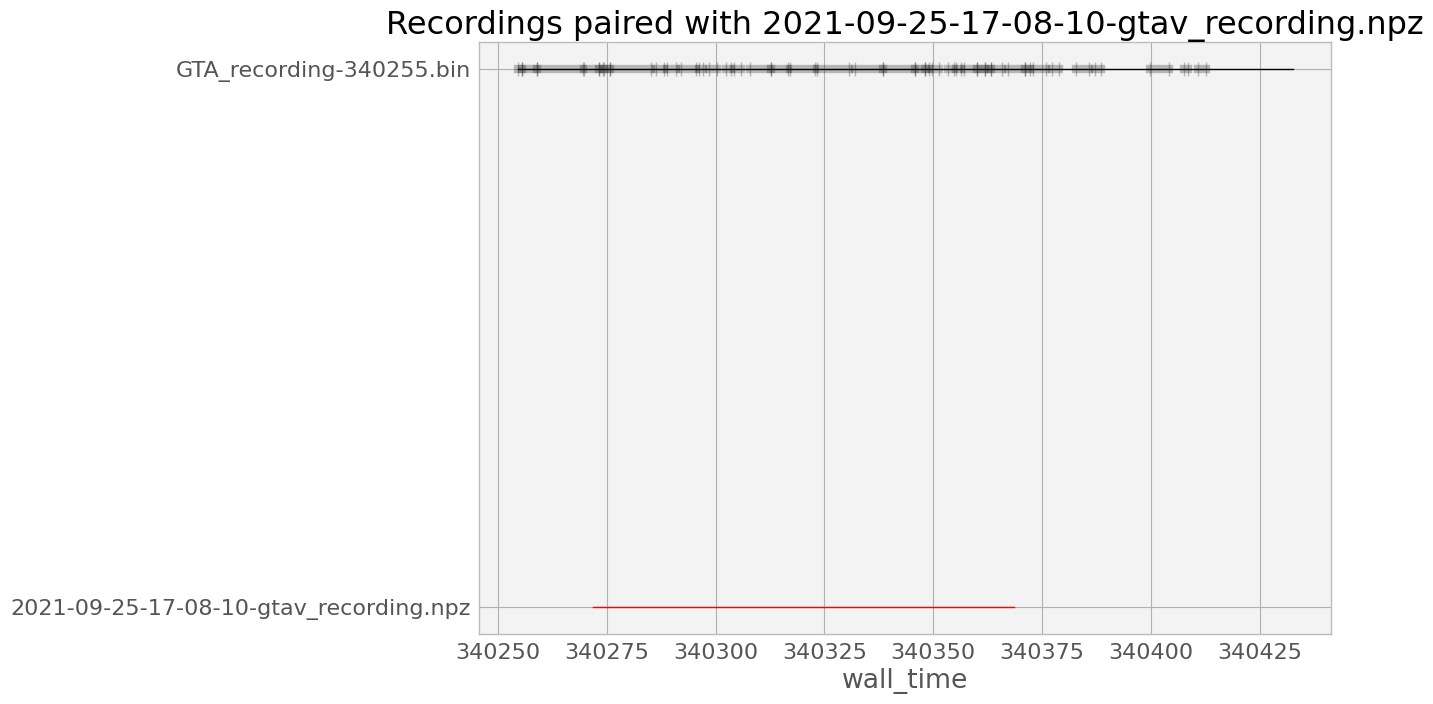

In [5]:
pairing = data['paired'][-2]
show_pairing_times(pairing)

In [6]:
telemetry_recording = pairing.telemetry_recordings[0]

In [7]:
len([pv.duration for pv in [track for track in telemetry_recording.track_manager.tracks 
                 if track.is_player and track.is_vehicle]])

228

In [8]:
telemetry_recording.track_manager.merge_player_tracks()
player_tracks = [track for track in telemetry_recording.track_manager.tracks 
                 if track.is_player and track.is_vehicle]
len([pv.duration for pv in player_tracks])

1

In [9]:
player_tracks.sort(key=lambda t: t.duration)
longest_player_track = player_tracks[-1]

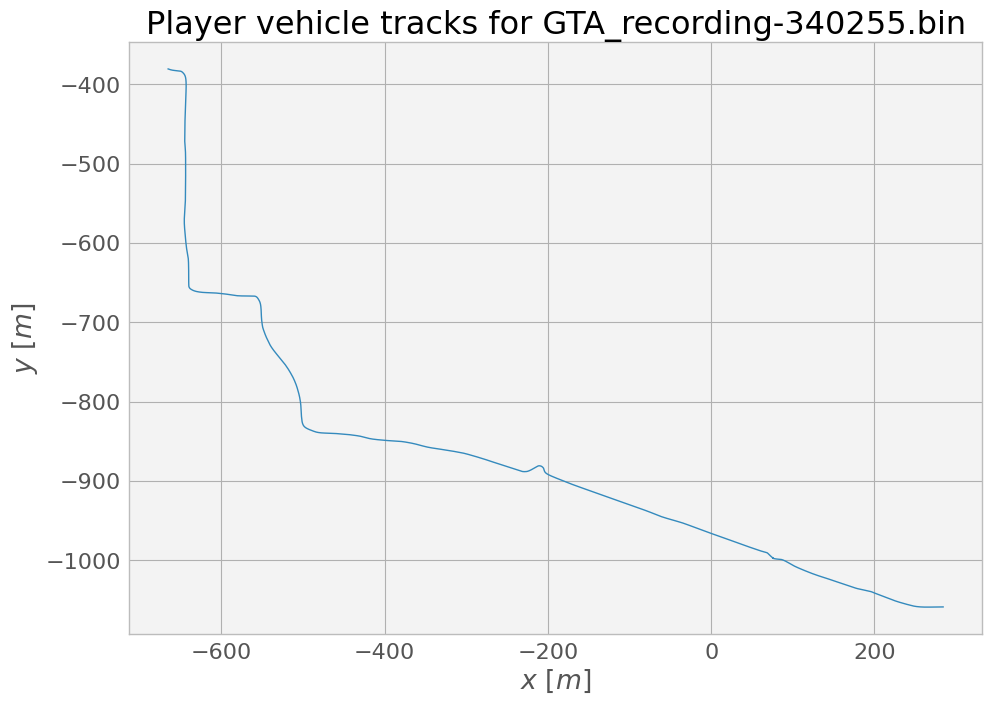

In [10]:
fig, ax = plt.subplots()
for pv in player_tracks:
    ax.plot(pv._get_data('posx'), pv._get_data('posy'))
ax.set_xlabel('$x$ $[m]$')
ax.set_ylabel('$y$ $[m]$')
ax.set_title('Player vehicle tracks for %s' % basename(telemetry_recording.fname));

In [68]:
import train_velocity_predictor
from importlib import reload as reload_module
reload_module(train_velocity_predictor)

<module 'train_velocity_predictor' from '/mnt/store/tsbertalan/Dropbox/Projects/GTARacer/bin/train_velocity_predictor.py'>

In [12]:
times, images, velocities, directional_velocities, vvecs, poses, forward_vectors, flow_from_previous = \
    train_velocity_predictor.pair_images_with_ego_velocities(pairing, LIMIT=None)

  0%|          | 0/571 [00:00<?, ?frames/s]

In [13]:
# del times, images, flow
# del flow_from_previous

In [14]:
# import gc
# gc.collect()

In [15]:
# imgs = pairing.image_recording.images
# times = pairing.image_recording.times
imgs = images
len(imgs), len(times)

(571, 571)

In [16]:
i1 = 10
i2 = i1 + 1

  0%|          | 0/1 [00:00<?, ?it/s]

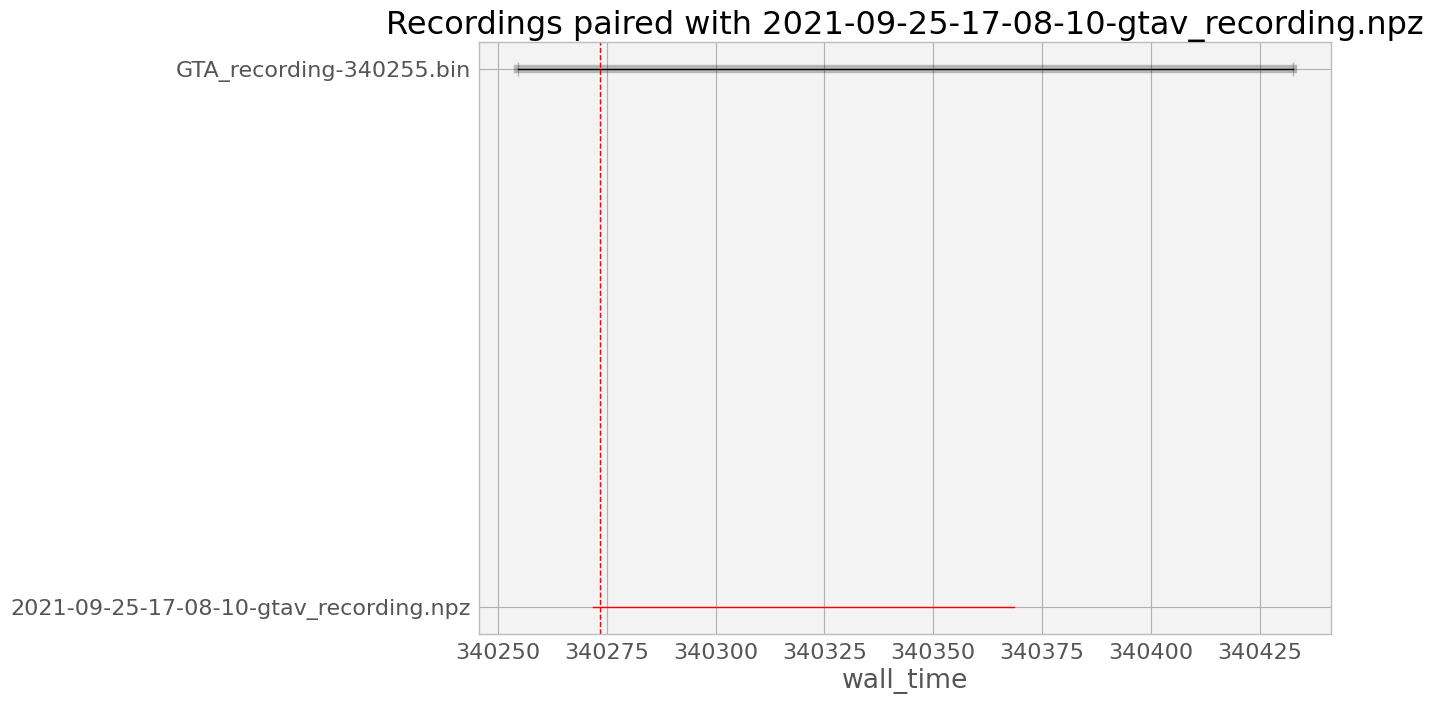

In [17]:
pairing = data['paired'][-2]
show_pairing_times(pairing)
ax = plt.gca()
ax.axvline(times[i1], color='red', linestyle='--')

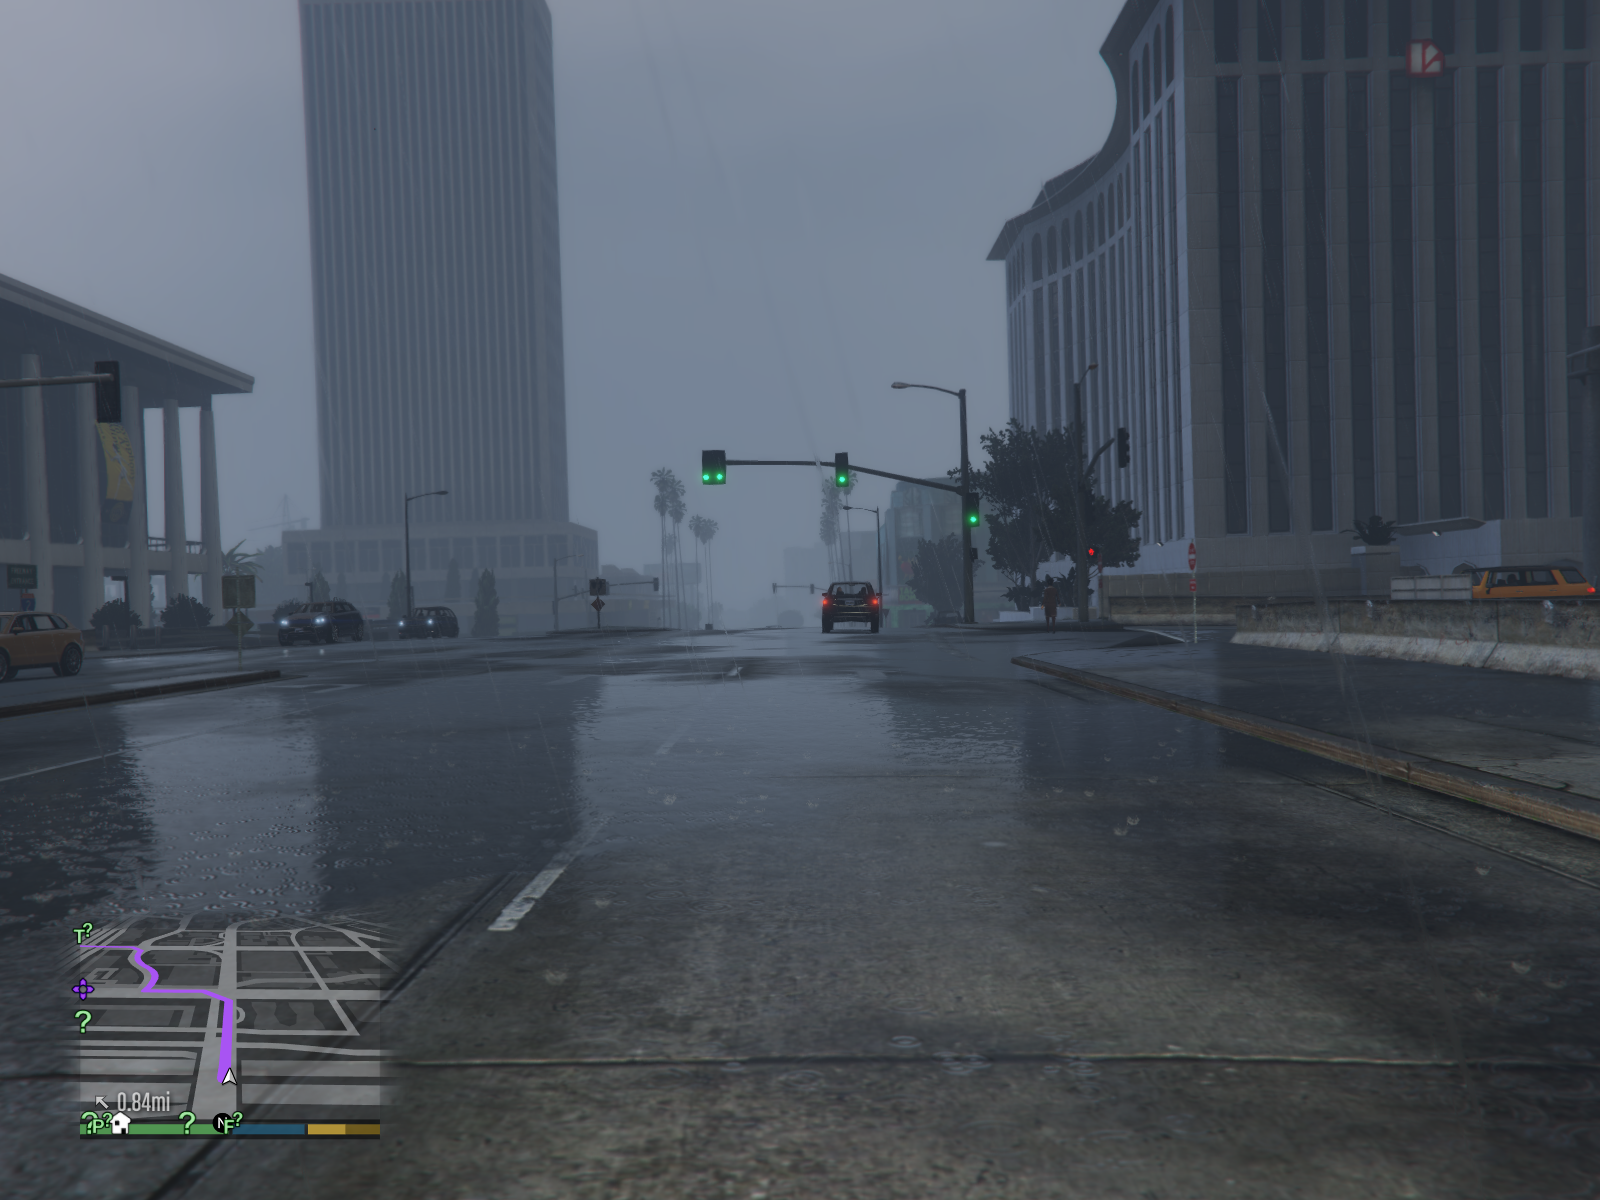

In [18]:
PIL.Image.fromarray(imgs[i1])

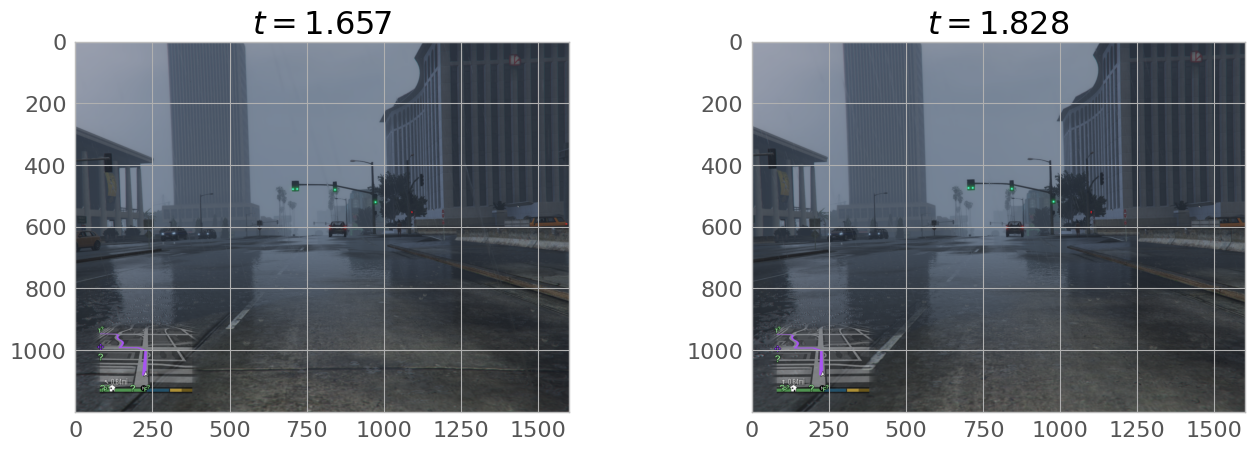

In [19]:
img1 = imgs[i1]
img2 = imgs[i2]
fig, (ax, bx) = plt.subplots(ncols=2, figsize=(16, 5))
ax.imshow(img1)
ax.set_title('$t=%.3f$' % (times[i1] - times[0]))
bx.imshow(img2, cmap='inferno')
bx.set_title('$t=%.3f$' % (times[i2] - times[0]));

In [20]:
# flow = train_velocity_predictor.convert_image_pair_to_optical_flow(imgs[i1], imgs[i2])
flow = flow_from_previous[i2]

In [21]:
flow.max()

51.060856

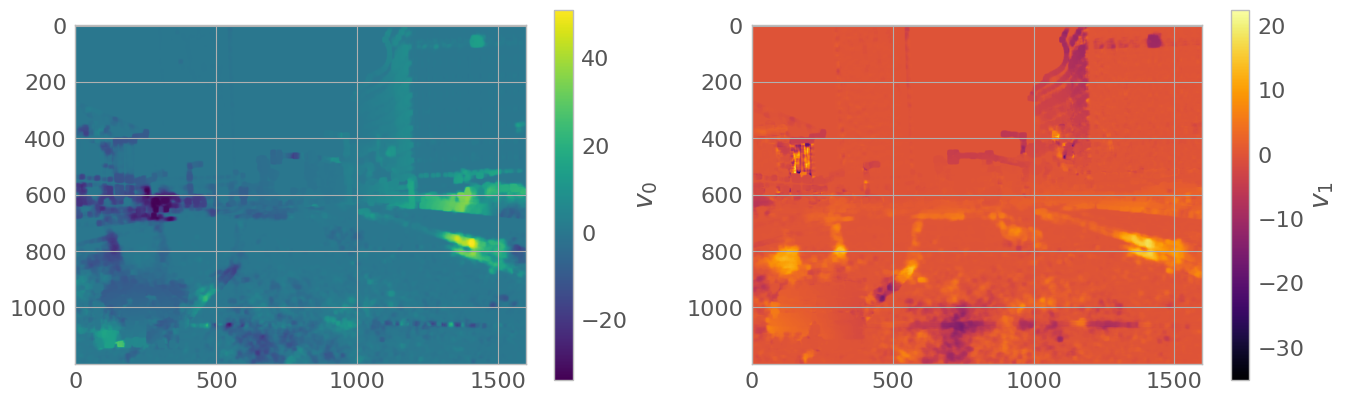

In [22]:
img1 = flow[..., 0]
img2 = flow[..., 1]
fig, (ax, bx) = plt.subplots(ncols=2, figsize=(16, 5))
fig.colorbar(ax.imshow(img1), ax=ax, label='$v_0$')
fig.colorbar(bx.imshow(img2, cmap='inferno'), ax=bx, label='$v_1$')

In [23]:
logf = np.log10(flow)
nan_spots = np.isnan(logf)
low_spots = logf == -np.inf
high_spots = logf == np.inf
ok_places = np.logical_and(
    np.logical_not(np.isnan(logf)),
    np.logical_not(np.isinf(logf))
)
logf.min(), logf.max()
logf[np.logical_not(nan_spots)].min(), logf[np.logical_not(nan_spots)].max()

/home/tsbertalan/.virtualenvs/GTARacer/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(-35.693512, 1.708088)

In [24]:
lowlog = np.min(logf[ok_places])
highlog = np.max(logf[ok_places])
logf[low_spots] = lowlog
logf[high_spots] = highlog
logf[nan_spots] = lowlog

In [25]:
logf[ok_places].min(), logf[ok_places].max()

(-35.693512, 1.708088)

In [26]:
# logf_uint8 = ((logf - logf[ok_places].min()) / (logf[ok_places].max() - logf[ok_places].min()) * 255).astype(np.uint8)

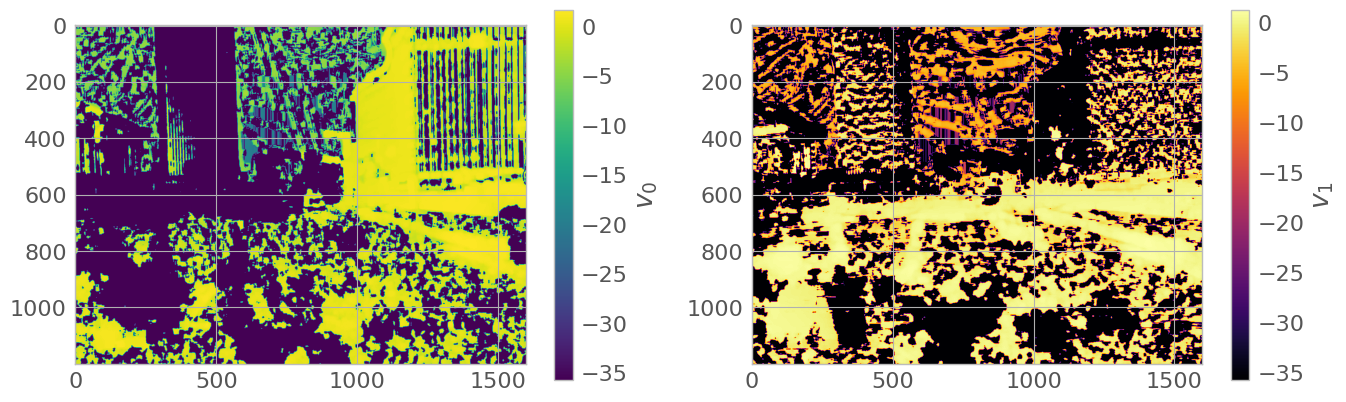

In [27]:
img1 = logf[..., 0]
img2 = logf[..., 1]
fig, (ax, bx) = plt.subplots(ncols=2, figsize=(16, 5))
fig.colorbar(ax.imshow(img1), ax=ax, label='$v_0$')
fig.colorbar(bx.imshow(img2, cmap='inferno'), ax=bx, label='$v_1$')

In [28]:
ti = longest_player_track.tmin
ta = longest_player_track.tmax
assert ti <= times[i1] <= ta, 'Chosen time is not in telemetry recording.'

In [29]:
nearest_ego_state = longest_player_track.get_interpolated_state(times[i1])

In [30]:
directional_velocities[i2]

8.446444300717115

In [31]:
flow.shape

(1200, 1600, 2)

In [32]:
1200/1600

0.75

In [33]:
import cv2

In [34]:
new_shape = 400, 300

flow_small = cv2.resize(flow, new_shape)

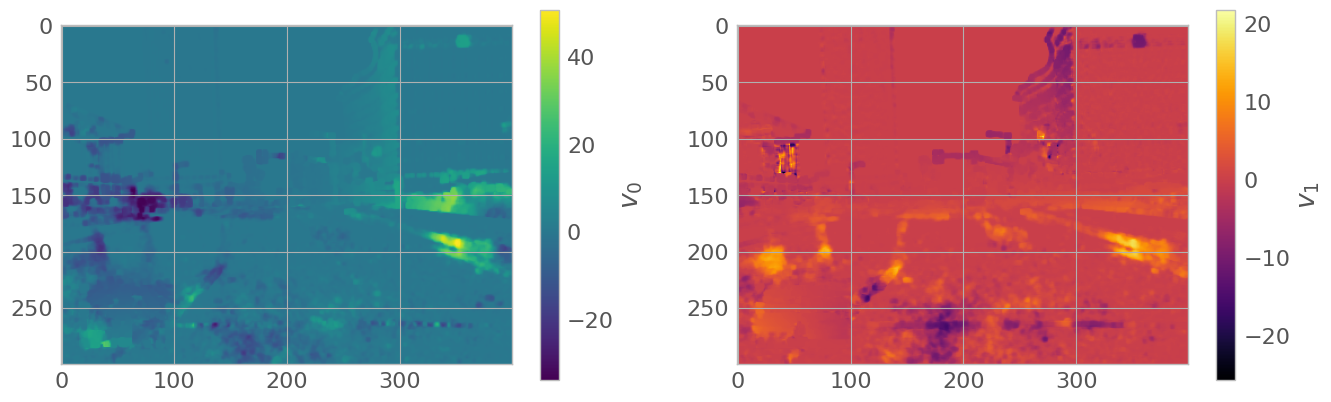

In [35]:
img1 = flow_small[..., 0]
img2 = flow_small[..., 1]
fig, (ax, bx) = plt.subplots(ncols=2, figsize=(16, 5))
fig.colorbar(ax.imshow(img1), ax=ax, label='$v_0$')
fig.colorbar(bx.imshow(img2, cmap='inferno'), ax=bx, label='$v_1$')

In [69]:
vel_predictor = train_velocity_predictor.VelocityPredictorFromOpticalFlow()

/home/tsbertalan/.virtualenvs/GTARacer/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [70]:
def shrink_img(img):
    return cv2.resize(img, (400, 300))

In [71]:
smol = shrink_img(flow)
vel_predictor.forward(torch.Tensor(
    np.rollaxis(smol, -1, 0).reshape((1, 2, smol.shape[0], smol.shape[1]))
))

tensor([[0.1735]], grad_fn=<AddmmBackward>)

In [72]:
vel_predictor.summarize()


  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 6.8 K 
--------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)


  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 6.8 K 
--------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)

In [74]:
directional_velocities[i2]

8.446444300717115

In [76]:
flow_from_previous[1].shape

(1200, 1600, 2)

In [78]:
flow_data = np.stack([
        shrink_img(im)
        for im in flow_from_previous[1:]
    ], axis=0).astype('float32')

In [84]:
print(flow_data.shape, flow_data.size * flow_data.itemsize / 1024 / 1024, 'mb')

(570, 300, 400, 2) 521.8505859375 mb


In [85]:
vel_data = np.array(directional_velocities[1:]).astype('float32')
vel_data.shape

(570,)

In [86]:
flow_data_NCHW = np.rollaxis(flow_data, -1, 1)
flow_data_NCHW.shape

(570, 2, 300, 400)

In [87]:
flow_data_NCHW.min(), flow_data_NCHW.max()

(-528.526, 442.85843)

In [98]:
full_dataset = torch.utils.data.TensorDataset(
    torch.from_numpy(flow_data_NCHW.astype('float32')),
    torch.from_numpy(vel_data.reshape(-1, 1).astype('float32'))
)

In [129]:
total_count = len(full_dataset)

In [131]:
train_count = int(0.8 * total_count)
valid_count = int(0.2 * total_count)
train_dataset, valid_dataset = torch.utils.data.random_split(
    full_dataset, (train_count, valid_count)
)

In [99]:
batch_size=32

In [100]:
from torch.utils.data import DataLoader

In [134]:
num_workers = 8

In [140]:
train_dataset_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
valid_dataset_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
dataloaders = {
    "train": train_dataset_loader,
    "val": valid_dataset_loader,
}
train_dataloaders = [dataloaders['train']]
val_dataloaders = [dataloaders['val']]

In [141]:
import pytorch_lightning as pl

In [142]:
model_save_dir = join('.', 'models')

In [143]:
model = vel_predictor

In [144]:
class LossRecorder(pl.Callback):

    def __init__(self):
        self.losses = []

    def on_before_backward(self, trainer, pl_module, loss):
        # # Do garbage collection.
        # import gc
        # gc.collect()
        self.losses.append(float(loss))

class PbarCallback(pl.Callback):

    def __init__(self, n_epochs):
        self.pbar = tqdm(total=n_epochs, unit='epoch', desc='Training')

    def on_epoch_end(self, trainer, pl_module):
        self.pbar.update(1)

    def on_train_end(self, trainer, pl_module):
        self.pbar.close()

loss_recorder = LossRecorder()

In [145]:
n_epochs = 1024
trainer = pl.Trainer(
    max_epochs=n_epochs, min_epochs=n_epochs, weights_save_path=model_save_dir, 
    progress_bar_refresh_rate=0,
    callbacks=[
        loss_recorder,
        PbarCallback(n_epochs),
        # pl.callbacks.EarlyStopping(patience=4, monitor='loss'),  # Needs a validation set.
    ]
)
trainer.fit(model, train_dataloaders=train_dataloaders, val_dataloaders=val_dataloaders)

Training:   0%|          | 0/1024 [00:00<?, ?epoch/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/tsbertalan/.virtualenvs/GTARacer/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f"you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop")

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 6.8 K 
--------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)
/home/tsbertalan/.virtualenvs/GTARacer/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:323: UserWarning: The number of training samples (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for th

tensor(0.0105, grad_fn=<DivBackward0>)
tensor(0.2234, grad_fn=<DivBackward0>)
tensor(0.0487, grad_fn=<DivBackward0>)
tensor(0.0873, grad_fn=<DivBackward0>)
tensor(0.2481, grad_fn=<DivBackward0>)
tensor(0.0818, grad_fn=<DivBackward0>)
tensor(0.0420, grad_fn=<DivBackward0>)
tensor(0.0263, grad_fn=<DivBackward0>)
tensor(0.1174, grad_fn=<DivBackward0>)
tensor(0.4263, grad_fn=<DivBackward0>)
tensor(0.0439, grad_fn=<DivBackward0>)
tensor(0.0830, grad_fn=<DivBackward0>)
tensor(0.0177, grad_fn=<DivBackward0>)
tensor(0.0361, grad_fn=<DivBackward0>)
tensor(0.5751, grad_fn=<DivBackward0>)


Exception ignored in: <function _releaseLock at 0x7fe745f8cb00>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 16137, 16145, 16153, 16161, 16169, 16177, 16185) exited unexpectedly

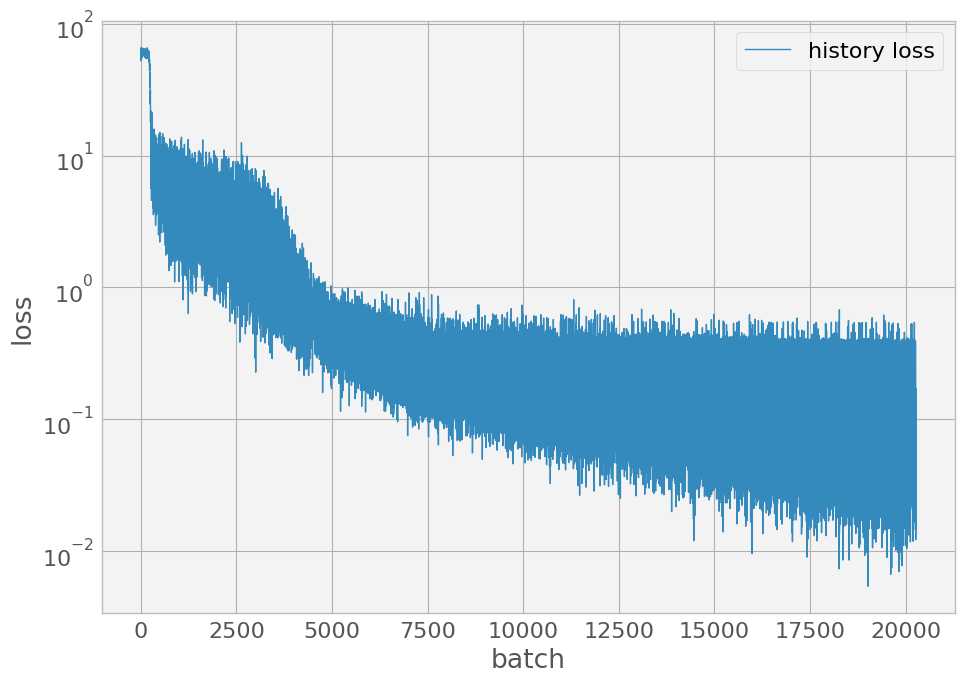

In [122]:
fig, ax = plt.subplots(1, 1)
l = loss_recorder.losses
ax.plot(l, label='history loss')
ax.legend()
ax.set_xlabel('batch')
ax.set_ylabel('loss')
ax.set_yscale('log')
fig.savefig(join(model_save_dir, 'loss.png'))

In [123]:
predictions = model.forward(full_dataset.tensors[0]).detach().numpy()

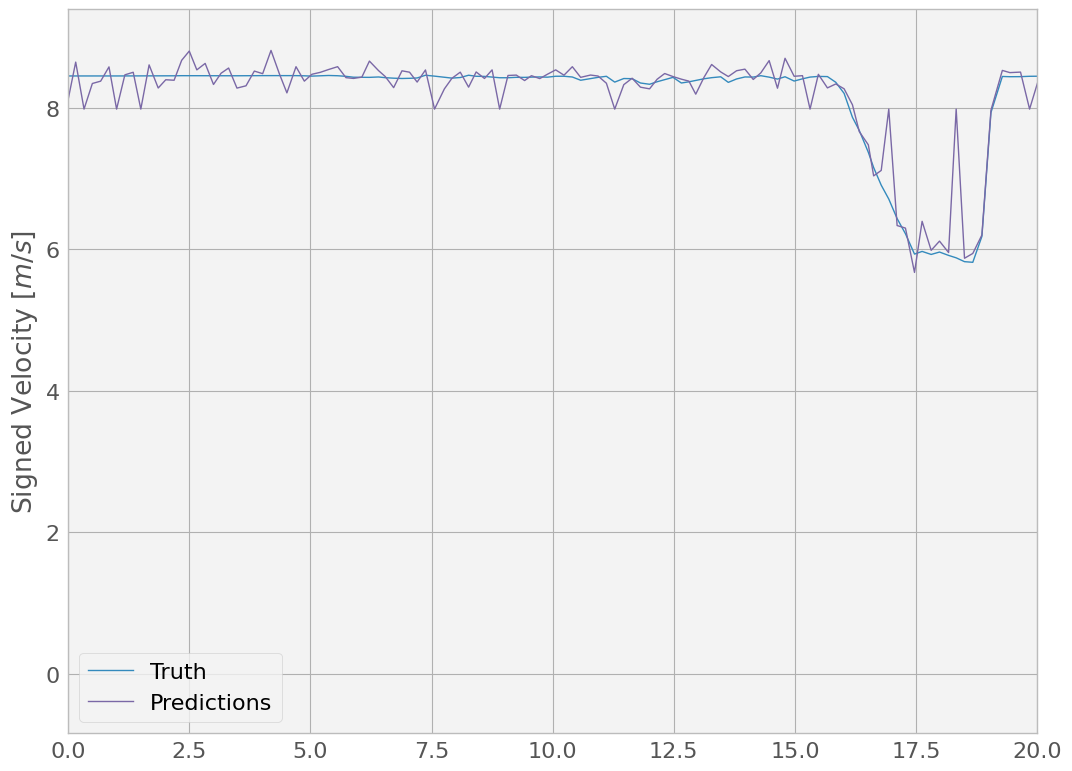

In [125]:
fig, ax = plt.subplots()
ax.plot(times[1:] - times[1], vel_data, label='Truth')
ax.plot(times[1:] - times[1], predictions.ravel(), label='Predictions')
ax.set_ylabel('Time $[s]$')
ax.legend()
ax.set_ylabel('Signed Velocity $[m/s]$')
ax.set_xlim(0, 20);
fig.tight_layout()
fig.savefig(join(model_save_dir, 'vel_predictions.png'));